In [22]:
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching.matcher.distance import DistanceMatcher
import leuvenmapmatching.visualization as mm_viz
import geopandas as gpd
import pandas as pd
import smopy
from rdp import rdp

In [3]:
#node = gpd.read_file('MOCT_NODE.shp')
link = gpd.read_file('MOCT_LINK.shp')

#노드자료 좌표계 변경 korea2000 -> wgs84
#node = node.to_crs({'init': 'epsg:4326'})

#링크자료 좌표계 변경 korea2000 -> wgs84
link = link.to_crs({'init': 'epsg:4326'})

In [4]:
#link에서 필요한 것만 나타내기
link = link[['LINK_ID','F_NODE','T_NODE','geometry']]

In [5]:
F_lat = []
F_lon = []
T_lat = []
T_lon = []

for i in range(0,len(link)):
    geom = link.iloc[i]['geometry']
        
    F_lat.append(geom.coords[0][1])
    F_lon.append(geom.coords[0][0])
    T_lat.append(geom.coords[-1][1])
    T_lon.append(geom.coords[-1][0])

In [6]:
link['F_lat'] = F_lat
link['F_lon'] = F_lon
link['T_lat'] = T_lat
link['T_lon'] = T_lon

map 생성

In [7]:
map_con = InMemMap("mymap", use_latlon=True, use_rtree=True, index_edges=True)

In [8]:
for nid, row in link[['F_NODE', 'T_NODE', 'F_lat', 'F_lon', 'T_lat','T_lon']].iterrows():
    f_node = int(row['F_NODE'])
    t_node = int(row['T_NODE'])

    #add_node: f_node(시점), t_node(종점)
    map_con.add_node(f_node, (row['F_lat'], row['F_lon']))
    map_con.add_node(t_node, (row['T_lat'], row['T_lon']))
    
    #add_edge
    map_con.add_edge(f_node, t_node)   

gps 데이터 가져오기

In [9]:
#gps data 불러오기
gps_data = pd.read_csv('Task1_20191105.csv')

#gps데이터에서 생성시간, 위도, 경도 데이터만 나타내기
gps_data = gps_data[['latitude', 'longitude']]

#이상치 제거 - 위도, 경도가 0이고, 속도가 0인 것(정지상태)
gps_data = gps_data[gps_data.latitude !=0]
gps_data = gps_data[gps_data.longitude !=0]
#gps_data = gps_data[gps_data.speed !="0.0mph"]



In [10]:
#rdp 미적용
#route_list = [tuple(x) for x in gps_data.to_numpy()]

In [11]:
#rdp 적용
#Florian Wilhelm - Handling GPS Data with Python https://youtu.be/9Q8nEA_0ccg
route = rdp(gps_data[['latitude','longitude']].values, epsilon=1e-5)

#route(array 형식)를 list 형식으로 바꾸기
route_list = [tuple(x) for x in route.tolist()]


In [12]:
#route_list 중 100개만 
track = route_list[50:100]

leuven map matching 적용하기

In [13]:
#일반도로의 경우 500, 고속도로의 경우 2000정도 max_dist 지정해줘야 함
#고소도로 포함: max_dist = 3000, min_prob_norm=0.0001, dist_noise=100정도 하면 돌아가긴 하나, 노트북이 멈춤
matcher = DistanceMatcher(map_con,
                              max_dist = 500, min_prob_norm=0.0001,
                              non_emitting_length_factor=0.75,
                              obs_noise=30, obs_noise_ne=30,
                              dist_noise=10,
                              max_lattice_width=5, 
                              non_emitting_states=True)
states, last_idx = matcher.match(track)

In [14]:
nodes = matcher.path_pred_onlynodes

Lowered zoom level to keep map size reasonable. (z = 14)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x2634dc9fdd8>)

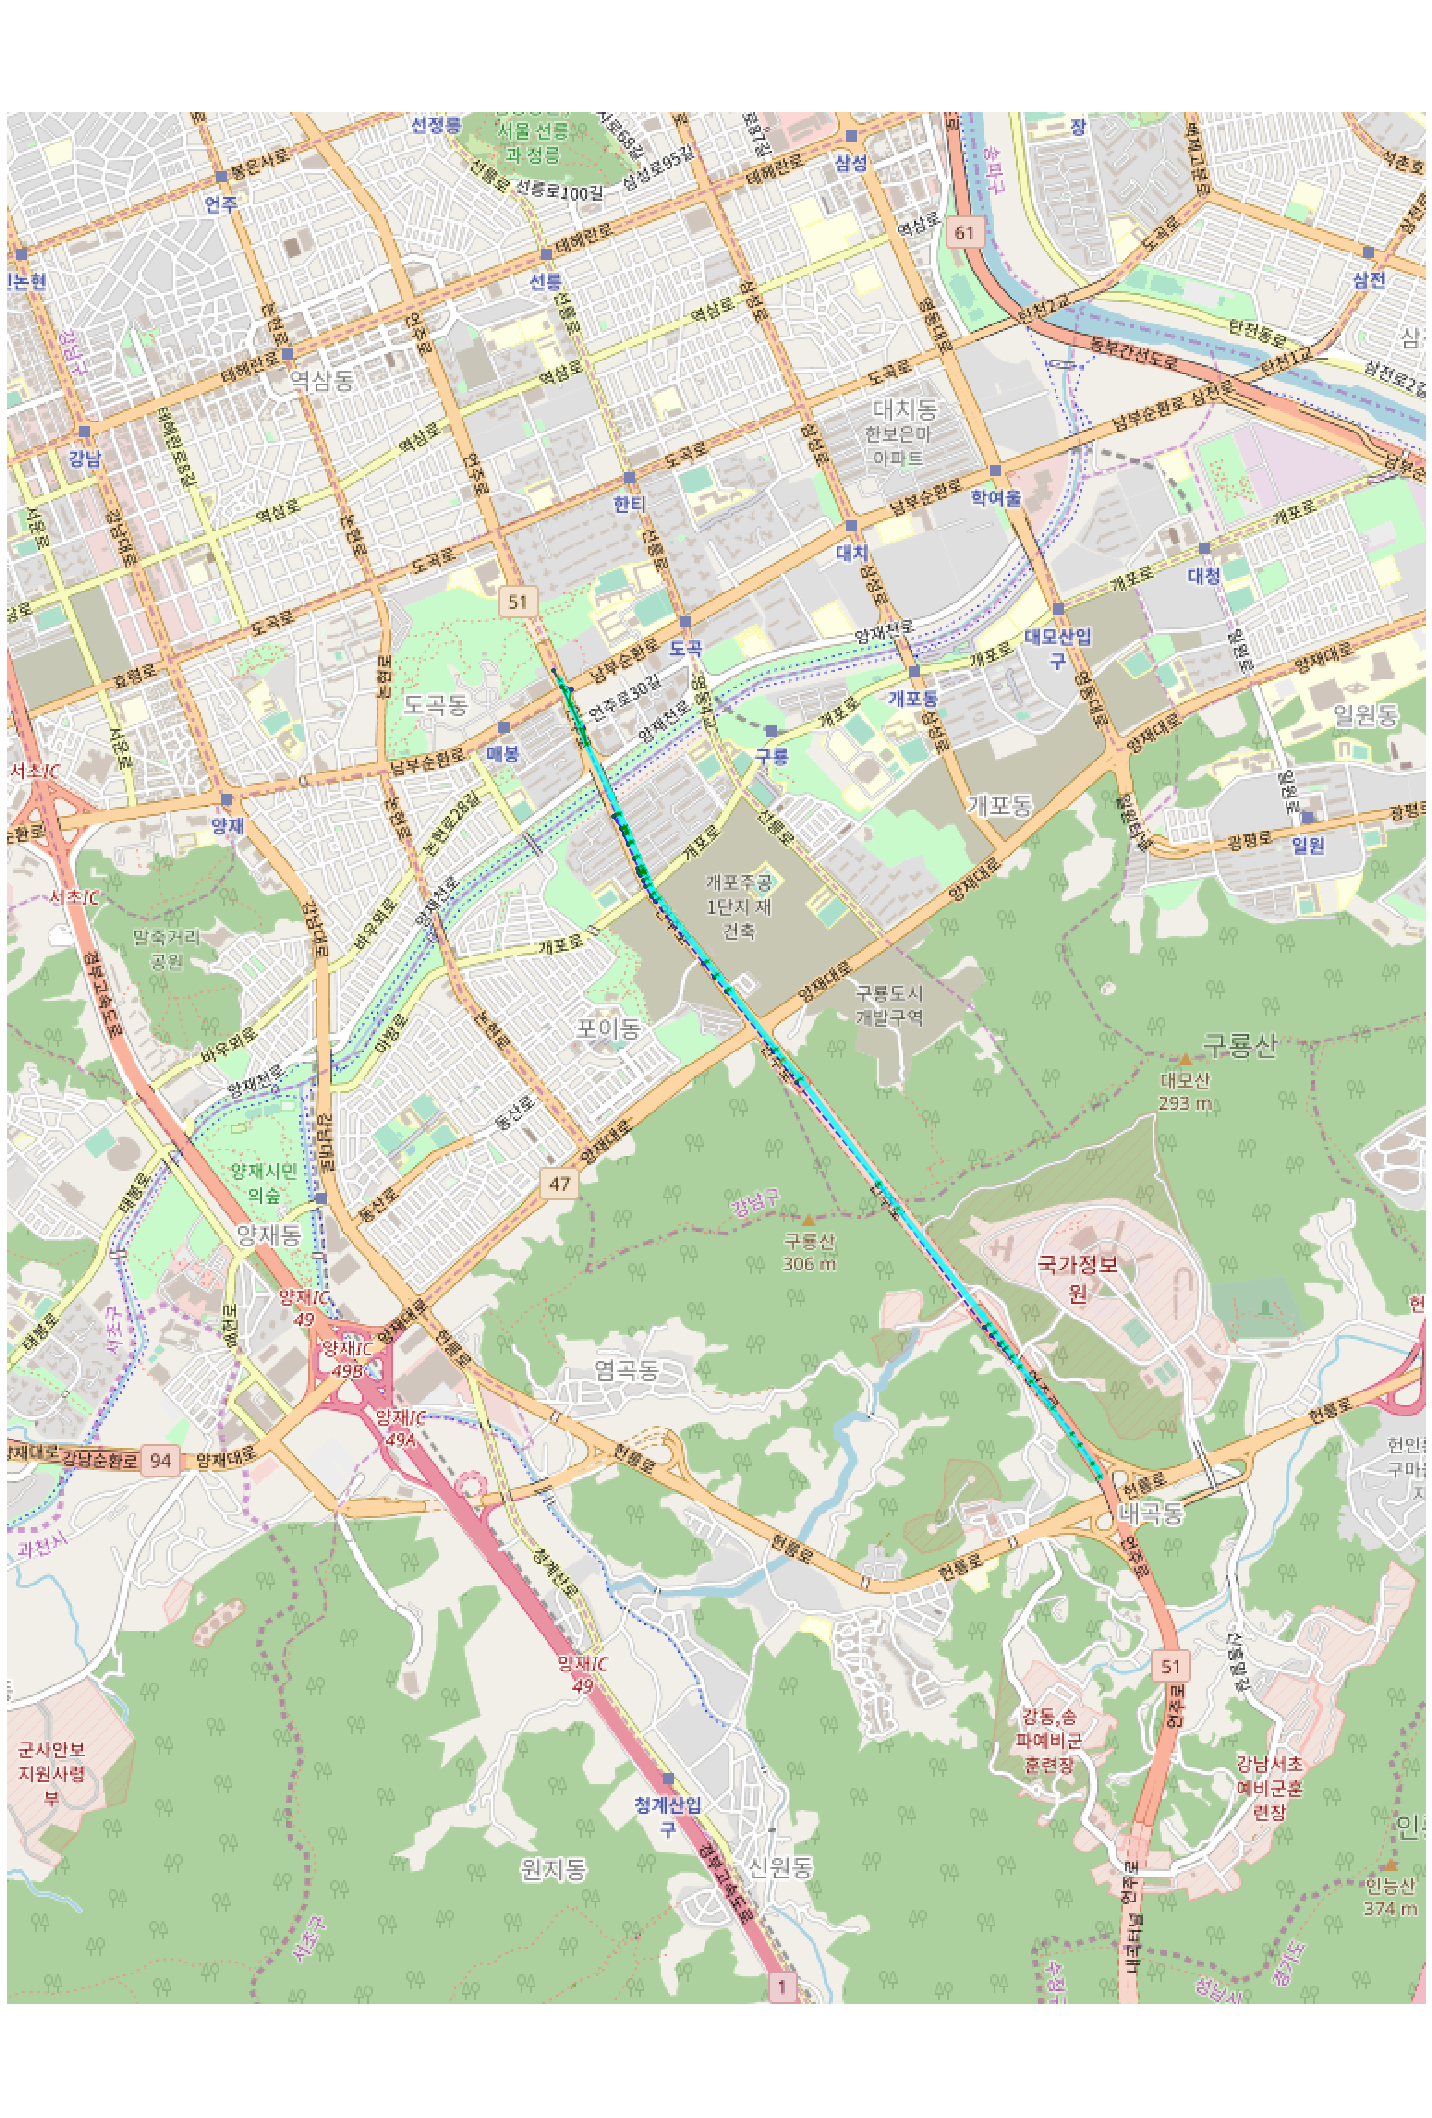

In [15]:
#leuven map matchin내의 메소드 이용하여 시각화
mm_viz.plot_map(map_con, matcher=matcher, use_osm=True,show_labels=False,
                zoom_path=True, show_graph=False, show_matching=True,
                filename=str("result.png"))


folium 이용한 시각화

In [33]:
def to_pixels(lat, lon=None):
    if lon is None:
        lat, lon = lat[0], lat[1]
    return lon, lat

In [64]:
#matching 노드의 좌푯값 찾기
def find_mid_nodes(matcher,  coords_list=None):
    coord_trans = None
    ax = None
    
    
    z=18
    
    bb = map_con.bb()    
    m = smopy.Map(bb, z=z, ax=ax)
    
    if matcher is not None:
        lat_nodes = matcher.lattice_best
    else:
        lat_nodes = None
    
    for idx, m in enumerate(lat_nodes):
        lat, lon = m.edge_m.pi[:2]
        #lat2, lon2 = m.edge_o.pi[:2]
        
        if coord_trans:
         #   lat, lon = coord_trans(lat, lon)
            lat2, lon2 = coord_trans(lat2, lon2)
    
        x,y = to_pixels(lat,lon)
        #x2, y2 = to_pixels(lat2, lon2)
        coords_list.append((y,x))   


In [65]:
coords_list = []
find_mid_nodes(matcher, coords_list)

Lowered zoom level to keep map size reasonable. (z = 7)


In [45]:
import folium
from matplotlib import pyplot as plt

In [46]:
#base_map 형식 지정하기
def generateBaseMap(default_location = [37.492397, 127.039084], default_zoom_start = 12):
    base_map = folium.Map(location = default_location, control_scale = True, zoom_start = default_zoom_start)
    return base_map

In [62]:
base_map = generateBaseMap()

In [67]:
#gps 데이터를 나타내기

'''
for i in range(0, len(coords_list)):
    folium.CircleMarker(location=[coords_list[i][1], coords_list[i][0]], radius=1, color='red').add_to(base_map)
    #folium.PolyLine(coords_list[i]).add_to(base_map)
'''

for each in coords_list:
    folium.Marker(each).add_to(base_map)


folium.PolyLine(coords_list).add_to(base_map)

base_map.save("gps2.html")